In [527]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

steps = []
for i in range(11):
    steps.append(i * 100)

In [528]:
def load_dataset(filename):
    data = open(filename, 'rt')
    x = np.loadtxt(data, delimiter = ",")
    X = torch.from_numpy(x)
    X = X.to(torch.float32)
    return X

In [529]:
def coupling_layer(w, b, m, z):
    X = torch.zeros((z.shape[0], z.shape[1]))
    X[:, m] = z[:, m]
    z_m = torch.reshape(z[:, m], (z[:, m].shape[0], 1))
    w = torch.reshape(w, (1, w.shape[0]))
    theta = torch.exp(torch.tanh(torch.mm(z_m, w) + b))
    X[:, 1-m] = z[:, 1-m] * theta[:, 0] + theta[:, 1]
    return X

def forward_flow(W, B, M, z0):
    Z = z0
    for i in range(len(M)):
        Z = coupling_layer(W[i], B[i], M[i], Z)
    return Z

def inverse_coupling_layer(w, b, m, x):
    Z = torch.zeros((x.shape[0], x.shape[1]))
    Z[:, m] = x[:, m]
    x_m = torch.reshape(x[:, m], (x[:, m].shape[0], 1))
    w = torch.reshape(w, (1, w.shape[0]))
    theta = torch.exp(torch.tanh(torch.mm(x_m, w) + b))
    Z[:, 1-m] = (x[:, 1-m] - theta[:, 1])/ theta[:, 0]
    log_det = torch.log(torch.abs(theta[:, 0]))
    return Z, log_det

def inverse_flow(W, B, M, X):
    log_jacob_det = 0
    for i in range(len(M)):
        X, log_det = inverse_coupling_layer(W[i], B[i], M[i], X)
        log_jacob_det += log_det
    return X, log_jacob_det

def log_likelihood(W, B, M, X):
    Z, log_jacob_det = inverse_flow(W, B, M, X)
    log_Pz = -((1/2)* Z.shape[1] * math.log(2 * math.pi)) - ((1/2) * torch.sum(Z * Z, dim = 1))
    log_Qx = log_Pz - log_jacob_det
    return log_Qx

In [530]:
def density_estimation(d, X, opt_steps = 1000):
    torch.manual_seed(0) #Results for different seed is included in the report
    W = torch.randn((d, 2), requires_grad=True, dtype = torch.float32)
    B = torch.randn((d, 2), requires_grad=True, dtype = torch.float32)
    M = torch.zeros(d, dtype = torch.int16)
    for i in range(len(M)):
        if i % 2 == 0:
            M[i] = 1
    
    optimizer = torch.optim.Adam([W, B], lr=0.3)
    
    for i in range(opt_steps):
        optimizer.zero_grad()
        loss = -torch.sum(log_likelihood(W, B, M, X))
        loss.backward()
        optimizer.step()

    return W, B, M

In [531]:
def model_depth(X):
    d = [2, 3, 4, 5]
    for i in range(len(d)):
        W, B, M = density_estimation(d[i], X)
        Z0 = torch.randn(1500, 2)
        X_estimated = forward_flow(torch.flipud(W.detach()), torch.flipud(B.detach()), torch.flipud(M), Z0)
        plt.title(f"Generated data distribution for depth d: {d[i]}\n")
        plt.hist2d(list(X_estimated[:,0]), list(X_estimated[:,1]), bins=100, range=[[-5,5],[-5,5]],  cmap = 'plasma')
        cb = plt.colorbar()
        plt.show()

def model_iterations(X, steps, d):

    log_prob = []
    
    for i in range(len(steps)):
        W, B, M = density_estimation(d, X, steps[i])
        Z0 = torch.randn(1500, 2)
        X_estimated = forward_flow(torch.flipud(W.detach()), torch.flipud(B.detach()), torch.flipud(M), Z0)
        plt.title(f"Generated data distribution for iterations: {steps[i]}\n")
        plt.hist2d(list(X_estimated[:,0]), list(X_estimated[:,1]), bins=100, range=[[-5,5],[-5,5]],  cmap = 'plasma')
        cb = plt.colorbar()
        plt.show()
        
        log_Qx = torch.sum(log_likelihood(W.detach(), B.detach(), M, X))
        log_prob.append(log_Qx)
    return log_prob

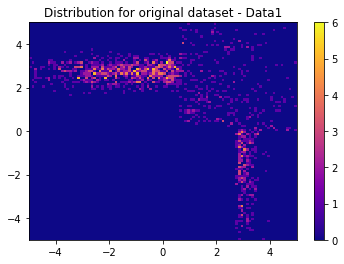

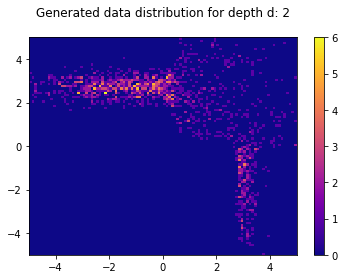

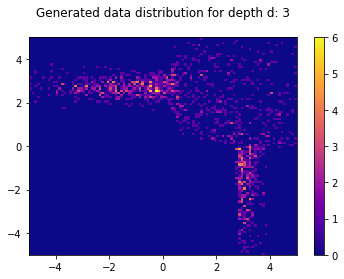

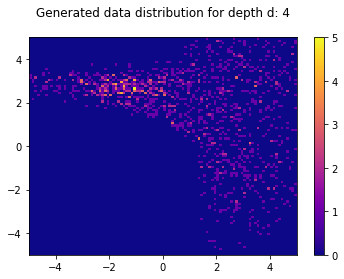

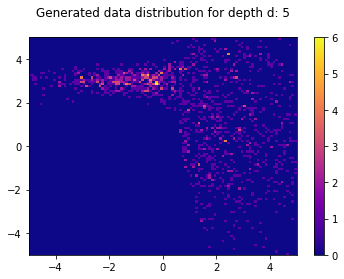

In [532]:
X_data1 = load_dataset('hw3data/data1.csv')
plt.title('Distribution for original dataset - Data1')
plt.hist2d(list(X_data1[:,0]), list(X_data1[:,1]), bins=100, range=[[-5,5],[-5,5]],  cmap = 'plasma')
cb = plt.colorbar()
plt.show()
model_depth(X_data1)

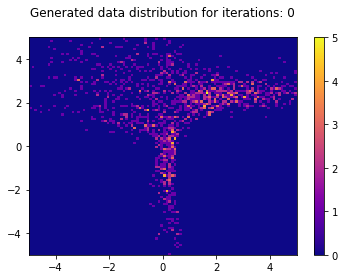

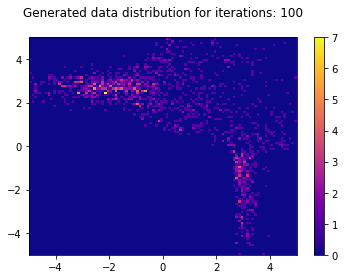

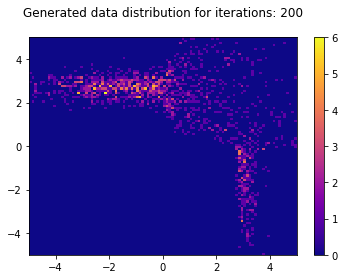

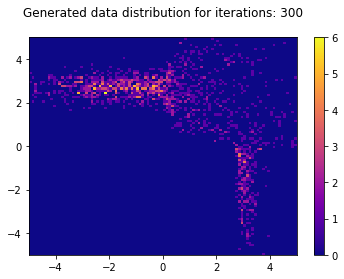

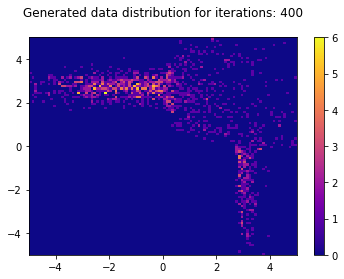

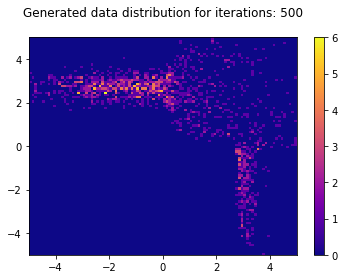

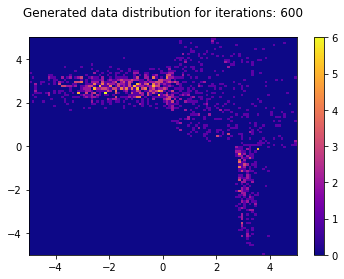

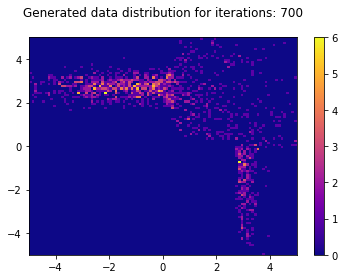

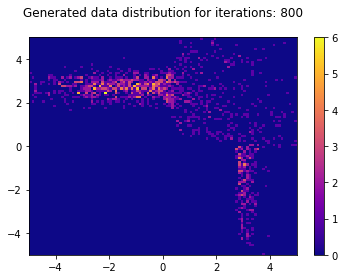

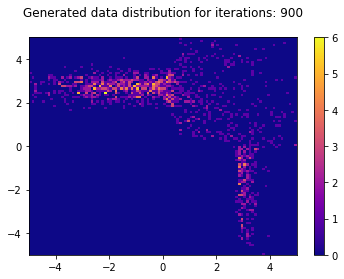

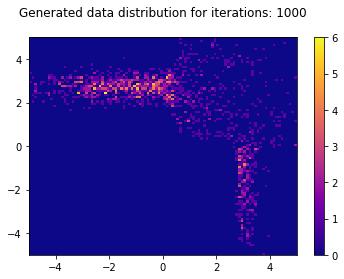

In [533]:
d = 2
log_prob = model_iterations(X_data1, steps, d)

log probabilities on Data1:
[tensor(-41779.7227), tensor(-5407.3677), tensor(-5153.8540), tensor(-5136.9263), tensor(-5123.6685), tensor(-5113.0664), tensor(-5104.3857), tensor(-5097.1304), tensor(-5090.9668), tensor(-5085.6641), tensor(-5081.0547)]



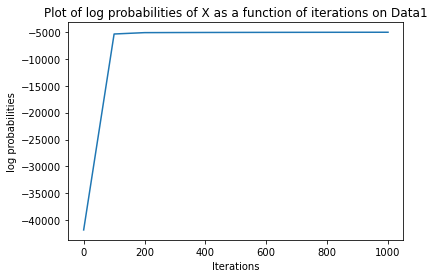

In [534]:
print(f'log probabilities on Data1:\n{log_prob}\n')
plt.title('Plot of log probabilities of X as a function of iterations on Data1')
plt.plot(steps, log_prob)
plt.ylabel('log probabilities')
plt.xlabel('Iterations')
plt.show()

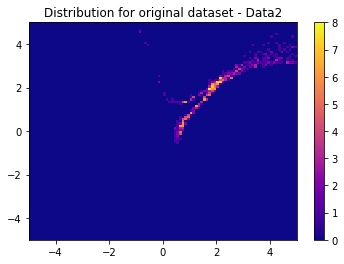

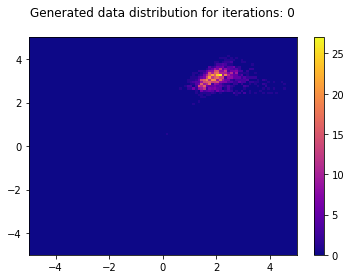

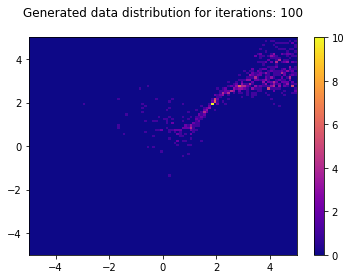

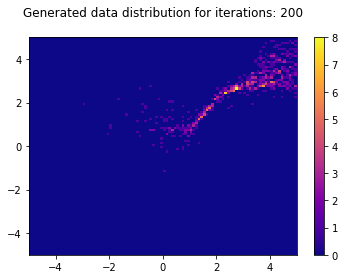

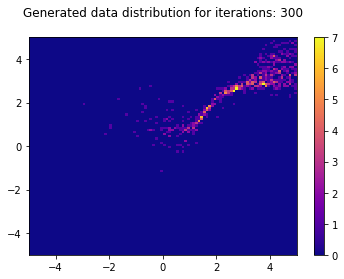

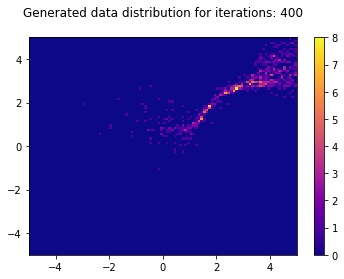

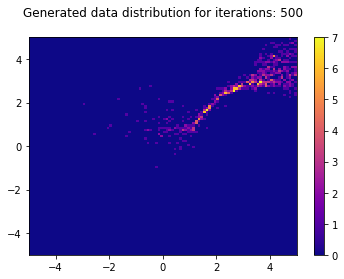

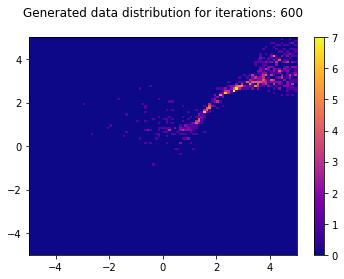

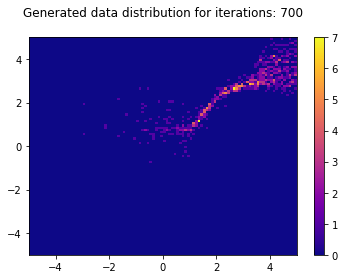

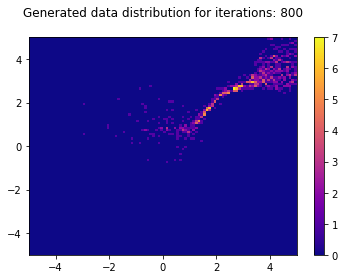

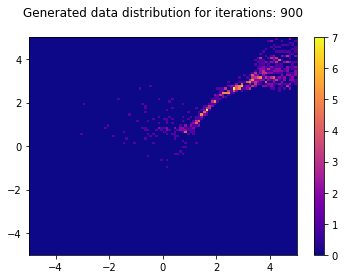

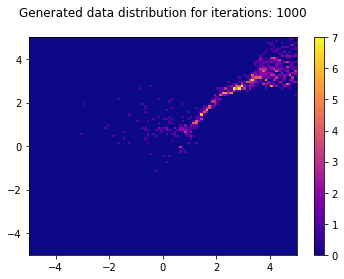

In [535]:
#Note: Please check plots for different iterations either on jupyter notebook or report
X_data2 = load_dataset('hw3data/data2.csv')
plt.title('Distribution for original dataset - Data2')
plt.hist2d(list(X_data2[:,0]), list(X_data2[:,1]), bins=100, range=[[-5,5],[-5,5]],  cmap = 'plasma')
cb = plt.colorbar()
plt.show()

d = 5
log_prob_data2 = model_iterations(X_data2, steps, d)

log probabilities on Data2:
[tensor(-552505.4375), tensor(-11608.2617), tensor(-11590.4629), tensor(-11584.8848), tensor(-11580.2969), tensor(-11575.6934), tensor(-11570.8301), tensor(-11569.2666), tensor(-11558.5947), tensor(-11553.1562), tensor(-11543.3604)]



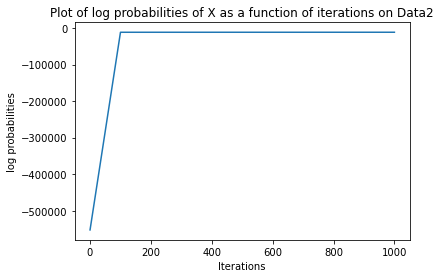

In [536]:
print(f'log probabilities on Data2:\n{log_prob_data2}\n')
plt.title('Plot of log probabilities of X as a function of iterations on Data2')
plt.plot(steps, log_prob_data2)
plt.ylabel('log probabilities')
plt.xlabel('Iterations')
plt.show()

In [537]:
#Extra Fun

def model_depth_extra(train_data, test_data, d):
    log_prob = []
    for i in range(len(d)):
        W, B, M = density_estimation(d[i], train_data)
        log_Qx = torch.sum(log_likelihood(W.detach(), B.detach(), M, test_data))
        log_prob.append(log_Qx)
    return log_prob

def model_iterations_extra(train_data, test_data, steps, d):
    log_prob = []
    for i in range(len(steps)):
        W, B, M = density_estimation(d, train_data, steps[i])
        log_Qx = torch.sum(log_likelihood(W.detach(), B.detach(), M, test_data))
        log_prob.append(log_Qx)
    return log_prob

log probabilities on Data1:
[tensor(-1655.6016), tensor(-1704.0582), tensor(-1957.4718), tensor(-2394.4875)]



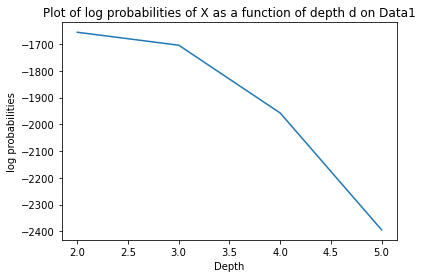

In [538]:
d = [2, 3, 4, 5]
split = int((2/3) * X_data1.shape[0])
datasets1 = torch.split(X_data1, split, dim=0)
train_data1 = datasets1[0]
test_data1 = datasets1[1]

log_p_data1_depth = model_depth_extra(train_data1, test_data1, d)
print(f'log probabilities on Data1:\n{log_p_data1_depth}\n')
plt.title('Plot of log probabilities of X as a function of depth d on Data1')
plt.plot(d, log_p_data1_depth)
plt.ylabel('log probabilities')
plt.xlabel('Depth')
plt.show()

log probabilities on Data1:
[tensor(-13768.1455), tensor(-1885.5620), tensor(-1683.3137), tensor(-1675.3910), tensor(-1670.0334), tensor(-1666.1263), tensor(-1663.1188), tensor(-1660.7136), tensor(-1658.7301), tensor(-1657.0519), tensor(-1655.6016)]



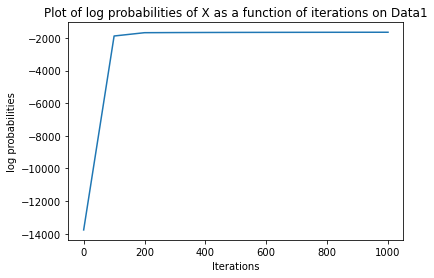

In [539]:
depth = 2
log_p_data1_iterations = model_iterations_extra(train_data1, test_data1, steps, depth)
print(f'log probabilities on Data1:\n{log_p_data1_iterations}\n')
plt.title('Plot of log probabilities of X as a function of iterations on Data1')
plt.plot(steps, log_p_data1_iterations)
plt.ylabel('log probabilities')
plt.xlabel('Iterations')
plt.show()

log probabilities on Data2:
[tensor(-4904.8975), tensor(-2342.2649), tensor(-2314.8252), tensor(-3622.0884)]



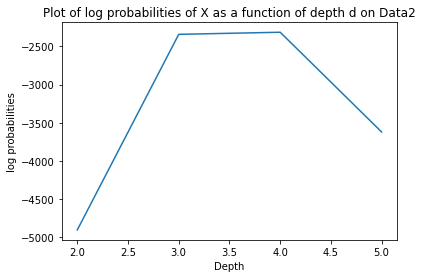

In [540]:
d = [2, 3, 4, 5]
split = int((2/3) * X_data2.shape[0])
datasets2 = torch.split(X_data2, split, dim=0)
train_data2 = datasets2[0]
test_data2 = datasets2[1]

log_p_data2_depth = model_depth_extra(train_data2, test_data2, d)
print(f'log probabilities on Data2:\n{log_p_data2_depth}\n')
plt.title('Plot of log probabilities of X as a function of depth d on Data2')
plt.plot(d, log_p_data2_depth)
plt.ylabel('log probabilities')
plt.xlabel('Depth')
plt.show()

log probabilities on Data2:
[tensor(-29236.0605), tensor(-2604.7759), tensor(-2546.4441), tensor(-2514.4326), tensor(-2511.1411), tensor(-2486.1794), tensor(-2330.3091), tensor(-2327.0747), tensor(-2321.5166), tensor(-2317.4138), tensor(-2314.8252)]



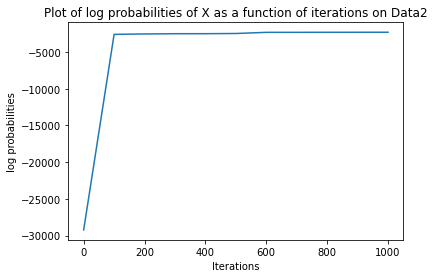

In [541]:
depth = 4
log_p_data2_iterations = model_iterations_extra(train_data2, test_data2, steps, depth)
print(f'log probabilities on Data2:\n{log_p_data2_iterations}\n')
plt.title('Plot of log probabilities of X as a function of iterations on Data2')
plt.plot(steps, log_p_data2_iterations)
plt.ylabel('log probabilities')
plt.xlabel('Iterations')
plt.show()